<a href="https://colab.research.google.com/github/inoueshinichi/PytorchTutorial/blob/main/PytorchTutorial_p1ch2_cyclegan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CycleGAN ウマをシマウマに変換するモデル

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

ResNetBlock

In [2]:
class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out

ResNet-Generator

In [3]:
class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf*mult, ngf*mult*2, kernel_size=3, stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf*mult*2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf*mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf*mult, int(ngf*mult/2), kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
                      nn.InstanceNorm2d(int(ngf*mult/2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [4]:
# 生成器
netG = ResNetGenerator()

In [5]:
# ウマとシマウマを変換する重みパラメータを読み込む(http://mng.bz/8pKP)
model_path = './dlwpt-code-master/data/p1ch2/horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

In [8]:
# 画像生成モード
netG.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

ウマ画像を読み込んでシマウマに変換する

In [9]:
from PIL import Image
from torchvision import transforms

In [10]:
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor()])

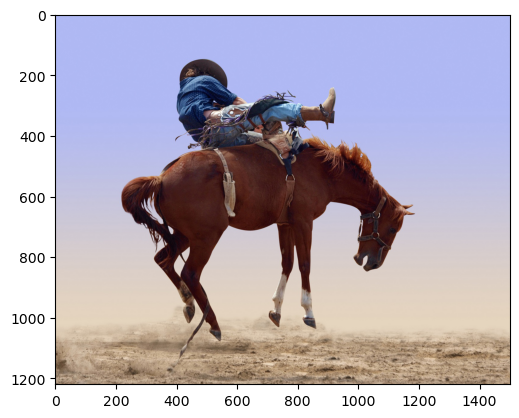

In [11]:
img = Image.open("./dlwpt-code-master/data/p1ch2/horse.jpg")
plt.imshow(np.array(img))

In [12]:
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)
print(batch_t.size())

torch.Size([1, 3, 256, 314])


In [13]:
# 画像生成
batch_out = netG(batch_t) # 生成器の出力

In [14]:
print(batch_out.size())

torch.Size([1, 3, 256, 316])


<PIL.Image.Image image mode=RGB size=316x256 at 0x22D6C3EA7F0>


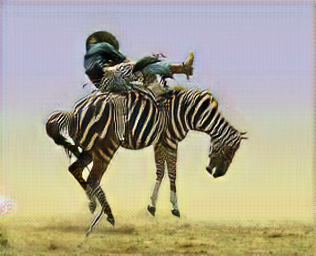

In [16]:
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
print(out_img)
out_img

In [18]:
out_t

tensor([[[0.6734, 0.6711,  ..., 0.7268, 0.7394],
         [0.6920, 0.6798,  ..., 0.6972, 0.7141],
         ...,
         [0.5852, 0.5588,  ..., 0.7254, 0.7069],
         [0.5510, 0.5196,  ..., 0.7025, 0.6909]],

        [[0.6252, 0.6057,  ..., 0.6841, 0.7013],
         [0.6026, 0.6063,  ..., 0.6480, 0.6681],
         ...,
         [0.6002, 0.5452,  ..., 0.6669, 0.6294],
         [0.5638, 0.5656,  ..., 0.6521, 0.6473]],

        [[0.7209, 0.7123,  ..., 0.6975, 0.7194],
         [0.6850, 0.7119,  ..., 0.6627, 0.6953],
         ...,
         [0.3050, 0.2410,  ..., 0.4745, 0.4132],
         [0.2894, 0.2288,  ..., 0.4636, 0.4227]]])

torch.Size([256, 316, 3])


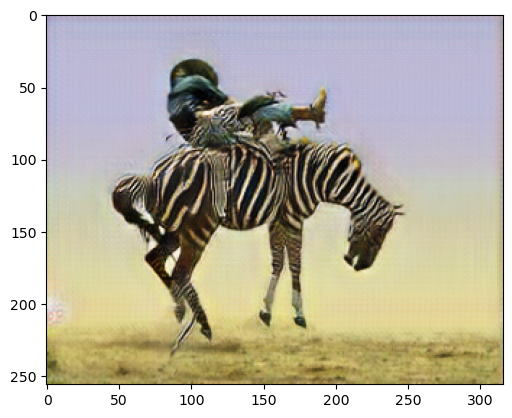

In [33]:
scaled_out_t = (out_t * 255).to(torch.uint8)
scaled_out_t = scaled_out_t.transpose(2, 0).transpose(0, 1)
print(scaled_out_t.size())
plt.imshow(scaled_out_t.to('cpu').detach().numpy().copy())
